# 5th_hometask

In [1]:
import numpy as np

from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import random

## 1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

### Генерация данных

In [2]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, random_state=1)

X.shape, y.shape

((1000, 2), (1000,))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

### Исходный код из методички

In [4]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [5]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 1 # ==================== Изменения ====================

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [14]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [16]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [17]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [18]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data, train_labels, test_labels):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

In [19]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

### Случайный лес из одного дерева

In [20]:
%%time
n_trees = 1 # ==================== Изменения ====================
my_forest_1 = random_forest(X_train, y_train, n_trees)

Wall time: 204 ms


In [21]:
# Получим ответы для обучающей выборки 
y_pred_train = tree_vote(my_forest_1, X_train)

In [22]:
# И получим ответы для тестовой выборки
y_pred_test = tree_vote(my_forest_1, X_test)

In [23]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train, y_pred_train)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(y_test, y_pred_test)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 93.125
Точность случайного леса из 1 деревьев на тестовой выборке: 84.500


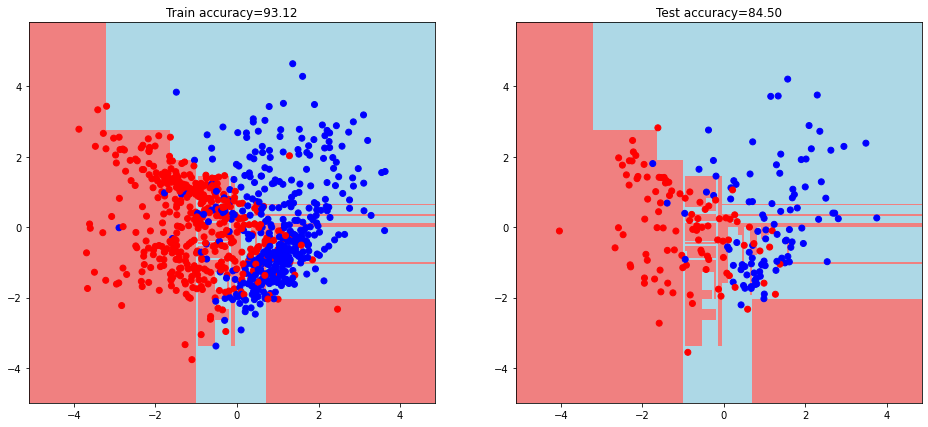

In [24]:
visualize(X_train, X_test, y_train, y_test)

### Случайный лес из трёх деревьев

In [25]:
%%time
n_trees = 3 # ==================== Изменения ====================
my_forest_3 = random_forest(X_train, y_train, n_trees)

Wall time: 563 ms


In [26]:
# Получим ответы для обучающей выборки 
y_pred_train = tree_vote(my_forest_3, X_train)

In [27]:
# И получим ответы для тестовой выборки
y_pred_test = tree_vote(my_forest_3, X_test)

In [28]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train, y_pred_train)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(y_test, y_pred_test)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 95.375
Точность случайного леса из 3 деревьев на тестовой выборке: 83.500


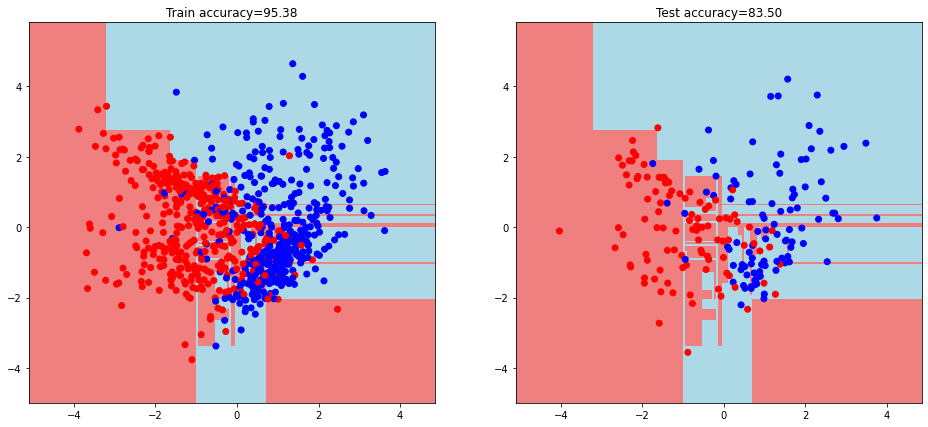

In [29]:
visualize(X_train, X_test, y_train, y_test)

##### Для трёх деревьев метрика на тестовом наборе данных с критерием Шеннона оказалась лучше.

### Случайный лес из десяти деревьев

In [30]:
%%time
n_trees = 10 # ==================== Изменения ====================
my_forest_10 = random_forest(X_train, y_train, n_trees)

Wall time: 2.04 s


In [31]:
# Получим ответы для обучающей выборки 
y_pred_train = tree_vote(my_forest_10, X_train)

In [32]:
# И получим ответы для тестовой выборки
y_pred_test = tree_vote(my_forest_10, X_test)

In [33]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train, y_pred_train)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(y_test, y_pred_test)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 98.250
Точность случайного леса из 10 деревьев на тестовой выборке: 86.000


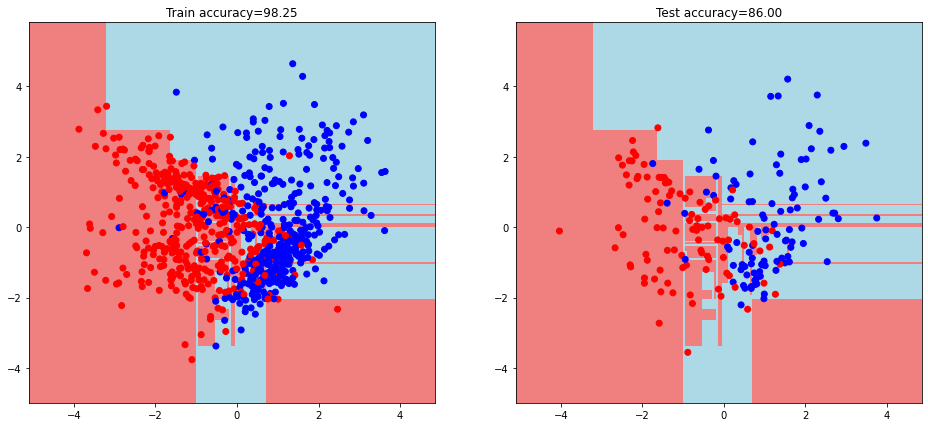

In [34]:
visualize(X_train, X_test, y_train, y_test)

##### Метрики улучшились на обоих наборах данных.

### Случайный лес из пятидесяти деревьев

In [35]:
%%time
n_trees = 50 # ==================== Изменения ====================
my_forest_50 = random_forest(X_train, y_train, n_trees)

Wall time: 10.5 s


In [36]:
# Получим ответы для обучающей выборки 
y_pred_train = tree_vote(my_forest_50, X_train)

In [37]:
# И получим ответы для тестовой выборки
y_pred_test = tree_vote(my_forest_50, X_test)

In [38]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train, y_pred_train)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(y_test, y_pred_test)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 99.875
Точность случайного леса из 50 деревьев на тестовой выборке: 88.000


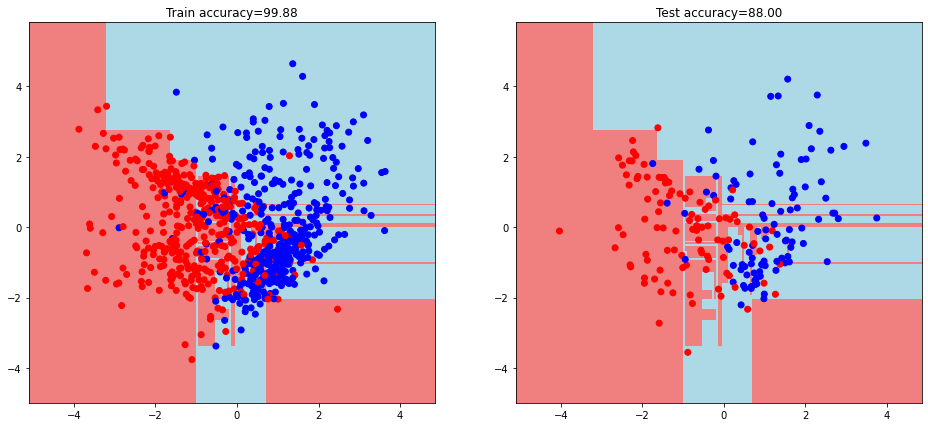

In [39]:
visualize(X_train, X_test, y_train, y_test)

##### Случайный лес из 50 деревьев практически идеально подогнался под обучающую выборку и показал ещё чуть более лучшую метрику на проверочной выборке в сравнении со случайным лесом из десяти деревьев.

### Вывод: проверка на практике показала, что увеличение количества деревьев в случайном лесу повышает эффективность модели.

## 2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

##### Визуально различия малозаметны. Из незначительного изменения метрик можно сделать вывод, что усложнения модели приводидили к незначительным изменениям визуализации. Однако увеличение метрик качества с усложнением модели, при обобщении ответов большего числа случайных деревьев, свидетельствует о более аккуратном разделении гиперпространства признаков. Так например, многочисленный ансамбль деревьев имеет меньший разброс ответов и при этом лучше справляется с задачей в случаях с выбросами, аномалиями или пограничными значениями.

## 3. *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

##### Для каждого дерева формируется набор объектов, которые не попали в bootstrap выборку для обучения. Затем все деревья делают прогноз на своих Out-of-Bag выборках, рассчитывается метрика accuracy. Итоговая метрика accuracy для всего леса является усреднением метрик всех случайных деревьев.

In [40]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        all_indexes = np.arange(0, n_samples) # ==================== Изменения ====================
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        # Получение индексов, которые присутствуют в исходной выборке, но отсутствуют в bootstrap выборке.
        oob_indexes = all_indexes[~np.in1d(all_indexes, sample_index)] # ==================== Изменения ====================
        oob_data = data[oob_indexes] # ==================== Изменения ====================
        oob_labels = labels[oob_indexes] # ==================== Изменения ====================
        
        bootstrap.append((b_data, b_labels, oob_data, oob_labels)) # ==================== Изменения ====================
        
    return bootstrap

In [41]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    oob_accuracy = [] # ==================== Изменения ====================
    
    for b_data, b_labels, oob_data, oob_labels in bootstrap: # ==================== Изменения ====================
        random_tree = build_tree(b_data, b_labels) # ==================== Изменения ====================
        
        forest.append(random_tree) # ==================== Изменения ====================
        
        # Прогноз и вычисление метрики accuracy на Out-of-Bag выборке.
        y_pred = predict(oob_data, random_tree) # ==================== Изменения ====================
        current_accuracy = accuracy_metric(oob_labels, y_pred) # ==================== Изменения ====================
        
        oob_accuracy.append(current_accuracy) # ==================== Изменения ====================
       
    # Вывод окончательной усреднённой метрики по всему случайному лесу.
    print(f"Out-of-Bag accuracy:\t{np.mean(oob_accuracy)}\n") # ==================== Изменения ====================
        
    return forest

In [42]:
%%time
n_trees = 1 # ==================== Изменения ====================
my_forest_1 = random_forest(X_train, y_train, n_trees)

Out-of-Bag accuracy:	82.25806451612904

Wall time: 207 ms


In [43]:
%%time
n_trees = 3 # ==================== Изменения ====================
my_forest_3 = random_forest(X_train, y_train, n_trees)

Out-of-Bag accuracy:	78.3147193585338

Wall time: 564 ms


In [44]:
%%time
n_trees = 10 # ==================== Изменения ====================
my_forest_10 = random_forest(X_train, y_train, n_trees)

Out-of-Bag accuracy:	80.43369339922694

Wall time: 2.06 s


In [45]:
%%time
n_trees = 50 # ==================== Изменения ====================
my_forest_50 = random_forest(X_train, y_train, n_trees)

Out-of-Bag accuracy:	81.08642707262032

Wall time: 10.6 s


##### Усреднённая метрика accuracy на Out-of-Bag наборе хуже, чем на учебных и проверочных наборах, так как деревья работают индивидуально с новыми для них данными. При этом дисперсия ответов одного дерева выше, чем ансамбля деревьев, поэтому метрика хуже.

## 4. *(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.

##### Чтобы избежать ошибки log(0) под знак логарифма также будем добавлять маленькое, близкое к нулю значение, которое не окажет существенного влиятия на вычисления.

In [46]:
# Расчет критерия Шэннона

def entropy(labels): # ==================== Изменения ====================
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    # Маленькое значение, чтобы под знаком логарифма не было нуля.
    anti_error = 1e-12 # ==================== Изменения ====================
    impurity = 0 # ==================== Изменения ====================
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p + anti_error) # ==================== Изменения ====================
        
    return np.round(impurity, 11) # ==================== Изменения ====================

In [47]:
# Расчет прироста

def gain(left_labels, right_labels, root_entropy): # ==================== Изменения ====================

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels) # ==================== Изменения 

In [48]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 1 # ==================== Изменения ====================

    root_entropy = entropy(labels) # ==================== Изменения ====================

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_entropy) # ==================== Изменения ====================
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

### Случайный лес из одного дерева

In [49]:
%%time
n_trees = 1 # ==================== Изменения ====================
my_forest_1 = random_forest(X_train, y_train, n_trees)

Out-of-Bag accuracy:	77.30263157894737

Wall time: 342 ms


In [50]:
# Получим ответы для обучающей выборки 
y_pred_train = tree_vote(my_forest_1, X_train)

In [51]:
# И получим ответы для тестовой выборки
y_pred_test = tree_vote(my_forest_1, X_test)

In [52]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train, y_pred_train)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(y_test, y_pred_test)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 91.375
Точность случайного леса из 1 деревьев на тестовой выборке: 81.500


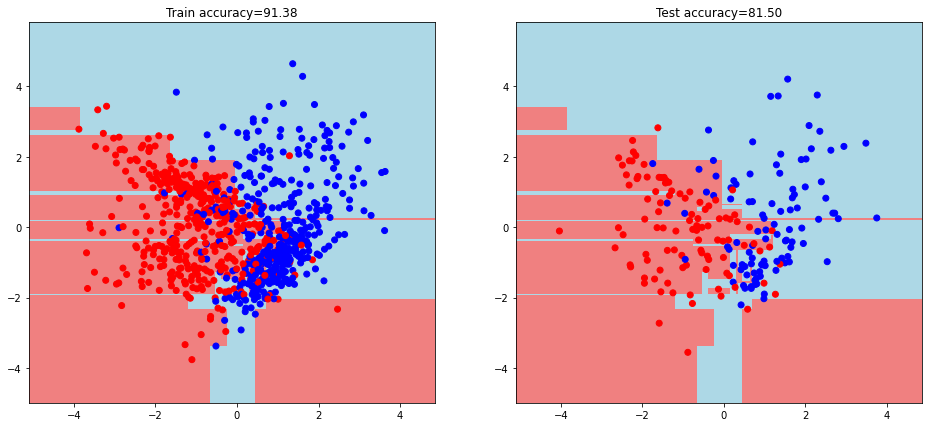

In [53]:
visualize(X_train, X_test, y_train, y_test)

##### Метрика незначительно ухудщилась в сравнении с критерием Джини.

### Случайный лес из трёх деревьев

In [54]:
%%time
n_trees = 3 # ==================== Изменения ====================
my_forest_3 = random_forest(X_train, y_train, n_trees)

Out-of-Bag accuracy:	81.4070648551439

Wall time: 879 ms


In [55]:
# Получим ответы для обучающей выборки 
y_pred_train = tree_vote(my_forest_3, X_train)

In [56]:
# И получим ответы для тестовой выборки
y_pred_test = tree_vote(my_forest_3, X_test)

In [57]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train, y_pred_train)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(y_test, y_pred_test)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 96.250
Точность случайного леса из 3 деревьев на тестовой выборке: 87.500


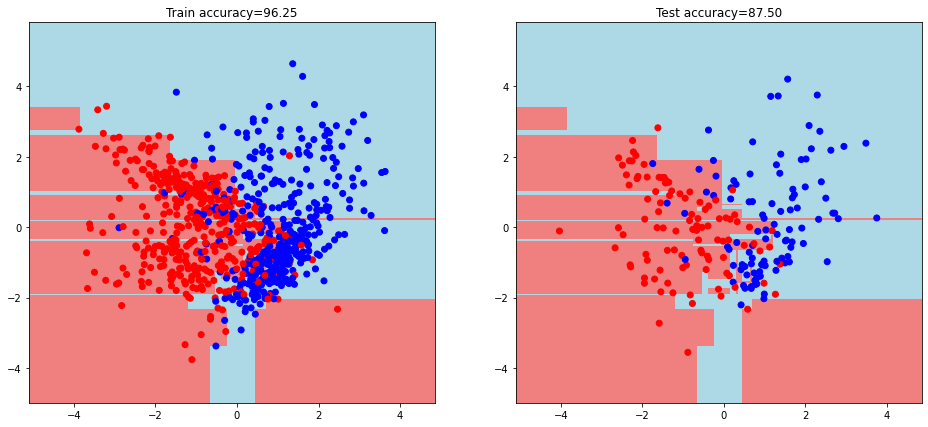

In [58]:
visualize(X_train, X_test, y_train, y_test)

##### Наблюдается улучшение метрик для обоих наборов данных.

### Случайный лес из десяти деревьев

In [59]:
%%time
n_trees = 10 # ==================== Изменения ====================
my_forest_10 = random_forest(X_train, y_train, n_trees)

Out-of-Bag accuracy:	80.17544827889256

Wall time: 3.18 s


In [60]:
# Получим ответы для обучающей выборки 
y_pred_train = tree_vote(my_forest_10, X_train)

In [61]:
# И получим ответы для тестовой выборки
y_pred_test = tree_vote(my_forest_10, X_test)

In [62]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train, y_pred_train)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(y_test, y_pred_test)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 98.875
Точность случайного леса из 10 деревьев на тестовой выборке: 84.000


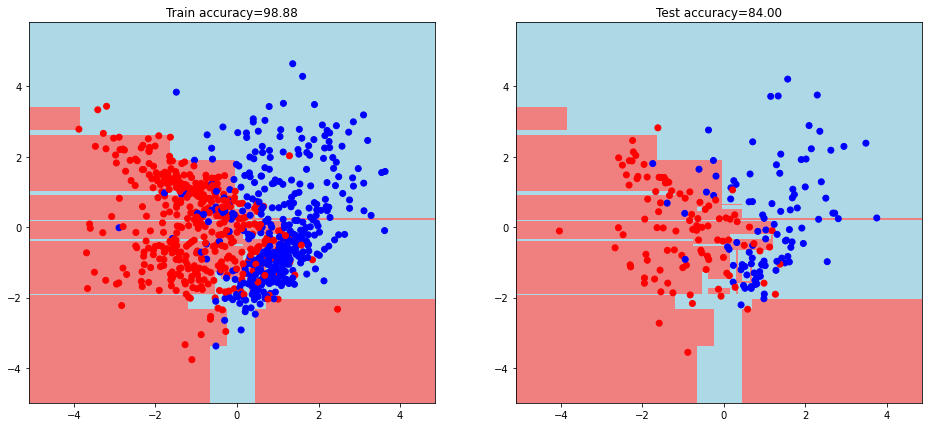

In [63]:
visualize(X_train, X_test, y_train, y_test)

##### Незначительное ухудшение метрики на проверочной выборке.

### Случайный лес из пятидесяти деревьев

In [64]:
%%time
n_trees = 50 # ==================== Изменения ====================
my_forest_50 = random_forest(X_train, y_train, n_trees)

Out-of-Bag accuracy:	81.21388106144441

Wall time: 14.6 s


In [65]:
# Получим ответы для обучающей выборки 
y_pred_train = tree_vote(my_forest_50, X_train)

In [66]:
# И получим ответы для тестовой выборки
y_pred_test = tree_vote(my_forest_50, X_test)

In [67]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train, y_pred_train)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(y_test, y_pred_test)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 99.625
Точность случайного леса из 50 деревьев на тестовой выборке: 86.500


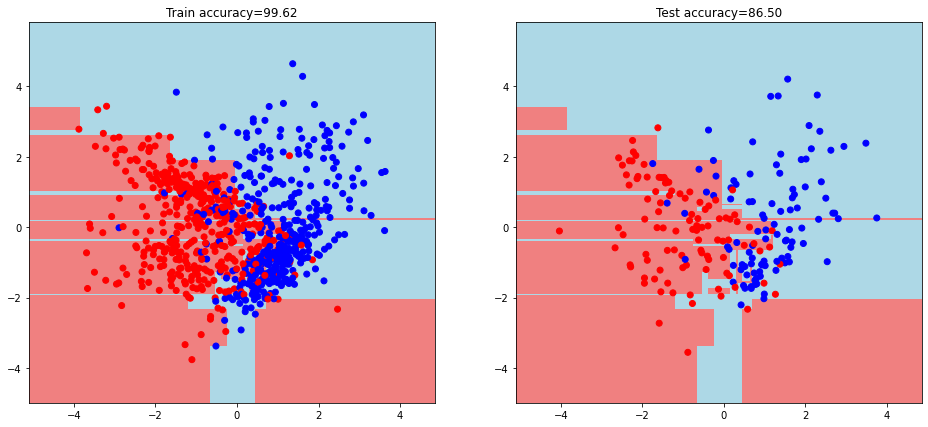

In [68]:
visualize(X_train, X_test, y_train, y_test)

##### Также наблюдается незначительное ухудшение метрики на проверочной выборке.